# U-Net Image Segmentation - GPU Acceleration Analysis

Ce notebook analyse les performances d'accélération GPU pour le modèle U-Net de segmentation d'images.

## Formule d'accélération

$$\text{Speedup} = \frac{\text{CPU time}}{\text{GPU time}}$$

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Chargement des Résultats

In [2]:
cpu_path = Path('runs/unet_cpu/results.json')
gpu_path = Path('runs/unet_cuda/results.json')

with open(cpu_path, 'r') as f:
    cpu_results = json.load(f)

with open(gpu_path, 'r') as f:
    gpu_results = json.load(f)

print("Résultats chargés avec succès")
print(f"  CPU training time: {cpu_results['total_time']:.2f}s")
print(f"  GPU training time: {gpu_results['total_time']:.2f}s")

Résultats chargés avec succès
  CPU training time: 1081.55s
  GPU training time: 52.38s


## 2. Calcul de l'Accélération GPU

In [3]:
cpu_time = cpu_results['total_time']
gpu_time = gpu_results['total_time']
speedup = cpu_time / gpu_time

print("="*70)
print("RÉSULTATS D'ACCÉLÉRATION GPU - U-NET")
print("="*70)
print(f"\nTemps total CPU:  {cpu_time:.2f}s")
print(f"Temps total GPU:  {gpu_time:.2f}s")
print(f"\nSpeedup:          {speedup:.2f}x")
print(f"Gain de temps:    {cpu_time - gpu_time:.2f}s ({(1 - gpu_time/cpu_time)*100:.1f}%)")
print("\nTemps moyen par epoch:")
print(f"  CPU: {np.mean(cpu_results['epoch_times']):.2f}s ± {np.std(cpu_results['epoch_times']):.2f}s")
print(f"  GPU: {np.mean(gpu_results['epoch_times']):.2f}s ± {np.std(gpu_results['epoch_times']):.2f}s")
print("="*70)

RÉSULTATS D'ACCÉLÉRATION GPU - U-NET

Temps total CPU:  1081.55s
Temps total GPU:  52.38s

Speedup:          20.65x
Gain de temps:    1029.17s (95.2%)

Temps moyen par epoch:
  CPU: 213.33s ± 2.81s
  GPU: 8.15s ± 0.16s


## 3. Comparaison des Métriques

In [4]:
data = {
    'Device': ['CPU', 'GPU'],
    'Total Time (s)': [cpu_time, gpu_time],
    'Avg Epoch Time (s)': [np.mean(cpu_results['epoch_times']), np.mean(gpu_results['epoch_times'])],
    'Final Dice Score': [cpu_results['test_dice'][-1], gpu_results['test_dice'][-1]],
    'Final Loss': [cpu_results['test_losses'][-1], gpu_results['test_losses'][-1]]
}

df = pd.DataFrame(data)
df['Speedup'] = ['1.00x', f'{speedup:.2f}x']
df

,Device,Total Time (s),Avg Epoch Time (s),Final Dice Score,Final Loss,Speedup
0,CPU,1081.548051,213.332980,1.000000,0.215986,1.00x
1,GPU,52.377677,8.154024,0.993127,0.231150,20.65x


## 4. Visualisation du Speedup

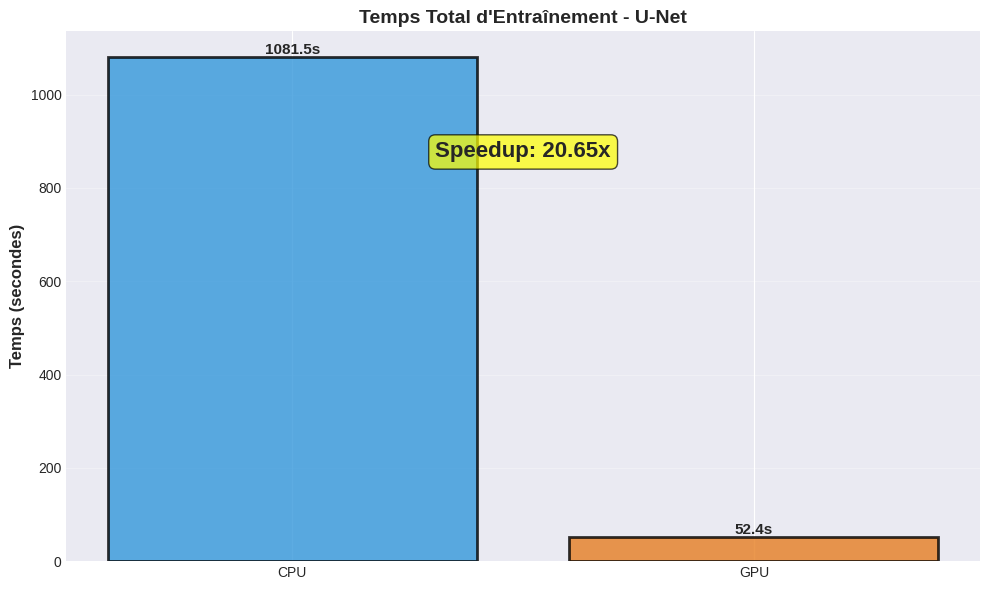

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bars = ax.bar(['CPU', 'GPU'], [cpu_time, gpu_time], 
               color=['#3498db', '#e67e22'], alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Temps (secondes)', fontsize=12, fontweight='bold')
ax.set_title('Temps Total d\'Entraînement - U-Net', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.text(0.5, max(cpu_time, gpu_time) * 0.8, 
        f'Speedup: {speedup:.2f}x', 
        ha='center', fontsize=16, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

## 5. Analyse du Profiling PyTorch

Analyse des opérations capturées par le profiler pendant l'entraînement.

In [6]:
import glob
import json as json_lib

def load_trace_data(trace_path):
    trace_files = glob.glob(f"{trace_path}/*.pt.trace.json")
    if not trace_files:
        return None
    
    with open(trace_files[0], 'r') as f:
        trace = json_lib.load(f)
    
    events = trace.get('traceEvents', [])
    op_events = [e for e in events if e.get('cat') == 'cpu_op' or e.get('cat') == 'kernel']
    
    op_stats = {}
    for event in op_events:
        name = event.get('name', 'unknown')
        dur = event.get('dur', 0) / 1000.0
        
        if name not in op_stats:
            op_stats[name] = {'count': 0, 'total_time': 0, 'times': []}
        
        op_stats[name]['count'] += 1
        op_stats[name]['total_time'] += dur
        op_stats[name]['times'].append(dur)
    
    return op_stats

cpu_trace = load_trace_data(cpu_results['profiler_path'])
gpu_trace = load_trace_data(gpu_results['profiler_path'])

if cpu_trace and gpu_trace:
    print("Traces de profiling chargées avec succès")
    print(f"  CPU: {len(cpu_trace)} types d'opérations")
    print(f"  GPU: {len(gpu_trace)} types d'opérations")
else:
    print("Impossible de charger les traces de profiling")

Traces de profiling chargées avec succès
  CPU: 86 types d'opérations
  GPU: 157 types d'opérations


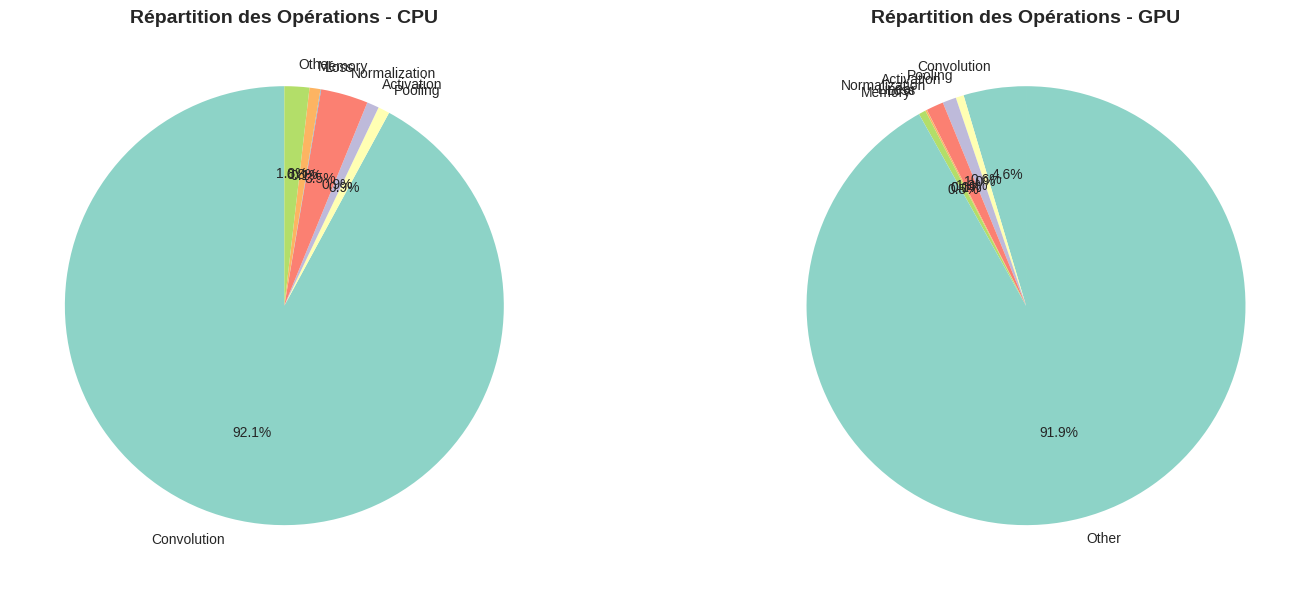


Répartition du temps par catégorie d'opérations:

Catégorie            CPU (ms)     GPU (ms)     Ratio
Convolution          3173138.64      5485.39   578.47x
Pooling                29445.58       706.55    41.68x
Activation             30732.71      1203.14    25.54x
Normalization         120048.72      1513.96    79.29x
Loss                    1802.80       148.75    12.12x
Memory                 27716.68       620.81    44.65x
Other                  63116.99    109775.46     0.57x


In [7]:
# Compare operation categories
if cpu_trace and gpu_trace:
    # Categorize operations
    def categorize_ops(trace):
        categories = {
            'Convolution': 0,
            'Pooling': 0,
            'Activation': 0,
            'Normalization': 0,
            'Linear': 0,
            'Loss': 0,
            'Memory': 0,
            'Other': 0
        }
        
        for name, stats in trace.items():
            name_lower = name.lower()
            if 'conv' in name_lower:
                categories['Convolution'] += stats['total_time']
            elif 'pool' in name_lower:
                categories['Pooling'] += stats['total_time']
            elif 'relu' in name_lower or 'sigmoid' in name_lower or 'tanh' in name_lower:
                categories['Activation'] += stats['total_time']
            elif 'norm' in name_lower or 'batch' in name_lower:
                categories['Normalization'] += stats['total_time']
            elif 'linear' in name_lower or 'addmm' in name_lower or 'matmul' in name_lower:
                categories['Linear'] += stats['total_time']
            elif 'loss' in name_lower or 'nll' in name_lower or 'cross' in name_lower:
                categories['Loss'] += stats['total_time']
            elif 'copy' in name_lower or 'clone' in name_lower or 'cat' in name_lower:
                categories['Memory'] += stats['total_time']
            else:
                categories['Other'] += stats['total_time']
        
        return categories
    
    cpu_categories = categorize_ops(cpu_trace)
    gpu_categories = categorize_ops(gpu_trace)
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # CPU pie chart
    cpu_values = [v for v in cpu_categories.values() if v > 0]
    cpu_labels = [k for k, v in cpu_categories.items() if v > 0]
    colors = plt.cm.Set3(range(len(cpu_labels)))
    
    wedges1, texts1, autotexts1 = ax1.pie(cpu_values, labels=cpu_labels, autopct='%1.1f%%',
                                            colors=colors, startangle=90)
    ax1.set_title('Répartition des Opérations - CPU', fontsize=14, fontweight='bold')
    
    # GPU pie chart
    gpu_values = [v for v in gpu_categories.values() if v > 0]
    gpu_labels = [k for k, v in gpu_categories.items() if v > 0]
    
    wedges2, texts2, autotexts2 = ax2.pie(gpu_values, labels=gpu_labels, autopct='%1.1f%%',
                                            colors=colors, startangle=90)
    ax2.set_title('Répartition des Opérations - GPU', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nRépartition du temps par catégorie d'opérations:")
    print(f"\n{'Catégorie':<20} {'CPU (ms)':<12} {'GPU (ms)':<12} {'Ratio'}")
    print("="*60)
    for cat in cpu_categories.keys():
        cpu_val = cpu_categories[cat]
        gpu_val = gpu_categories[cat]
        if cpu_val > 0 and gpu_val > 0:
            ratio = cpu_val / gpu_val
            print(f"{cat:<20} {cpu_val:>10.2f}   {gpu_val:>10.2f}   {ratio:>6.2f}x")
else:
    print("Données de profiling non disponibles")

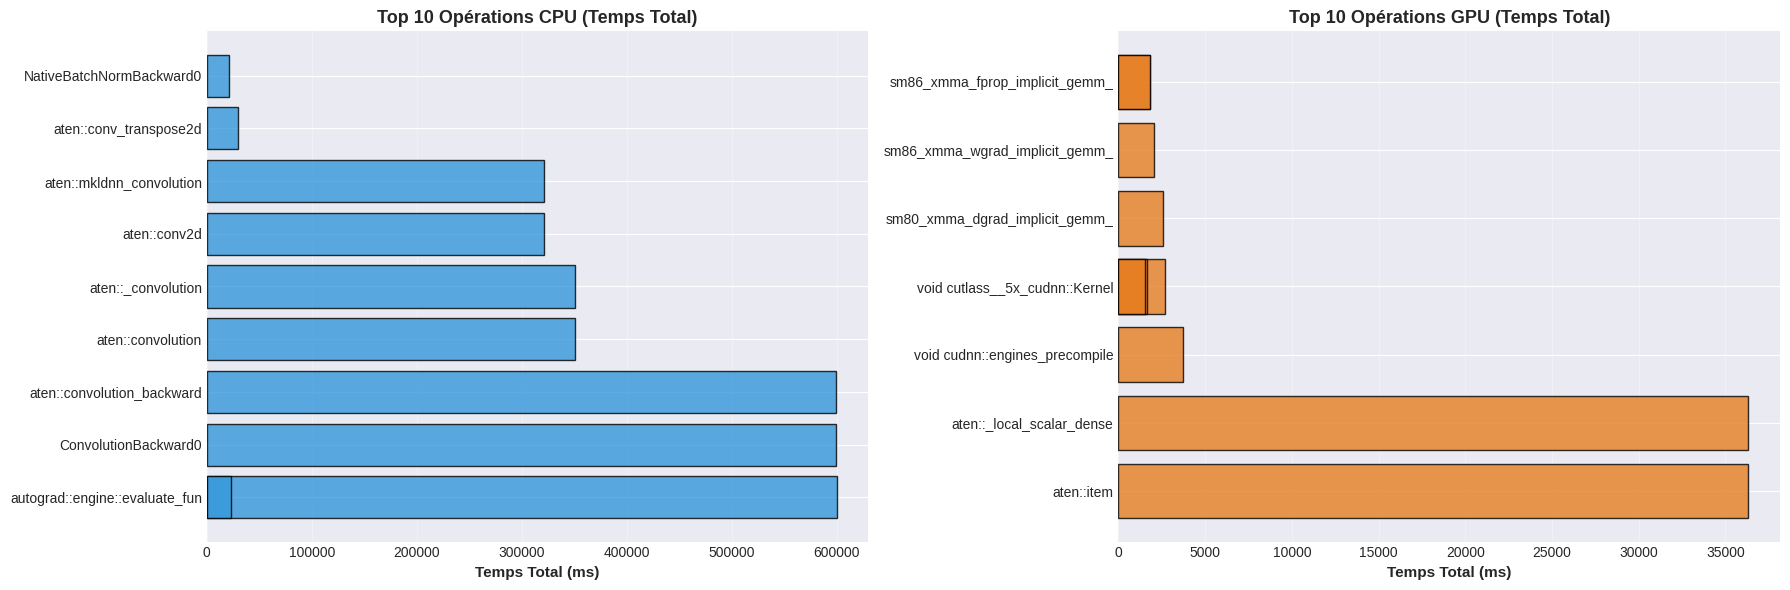


Top 5 opérations les plus coûteuses:

CPU:
  1. autograd::engine::evaluate_function: Con: 600214.95ms (7245 appels)
  2. ConvolutionBackward0: 599200.35ms (7245 appels)
  3. aten::convolution_backward: 599104.38ms (7245 appels)
  4. aten::convolution: 351160.08ms (8740 appels)
  5. aten::_convolution: 350969.19ms (8740 appels)

GPU:
  1. aten::item: 36338.24ms (52435 appels)
  2. aten::_local_scalar_dense: 36309.19ms (52435 appels)
  3. void cudnn::engines_precompiled::nchwToN: 3729.87ms (37550 appels)
  4. void cutlass__5x_cudnn::Kernel<cutlass_t: 2709.03ms (2190 appels)
  5. sm80_xmma_dgrad_implicit_gemm_tf32f32_tf: 2558.28ms (2200 appels)


In [8]:
# Top 10 operations by total time
if cpu_trace and gpu_trace:
    # Get top operations for CPU
    cpu_sorted = sorted(cpu_trace.items(), key=lambda x: x[1]['total_time'], reverse=True)[:10]
    gpu_sorted = sorted(gpu_trace.items(), key=lambda x: x[1]['total_time'], reverse=True)[:10]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # CPU top operations
    cpu_names = [name[:30] for name, _ in cpu_sorted]
    cpu_times = [stats['total_time'] for _, stats in cpu_sorted]
    
    bars1 = ax1.barh(cpu_names, cpu_times, color='#3498db', alpha=0.8, edgecolor='black')
    ax1.set_xlabel('Temps Total (ms)', fontsize=11, fontweight='bold')
    ax1.set_title('Top 10 Opérations CPU (Temps Total)', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # GPU top operations
    gpu_names = [name[:30] for name, _ in gpu_sorted]
    gpu_times = [stats['total_time'] for _, stats in gpu_sorted]
    
    bars2 = ax2.barh(gpu_names, gpu_times, color='#e67e22', alpha=0.8, edgecolor='black')
    ax2.set_xlabel('Temps Total (ms)', fontsize=11, fontweight='bold')
    ax2.set_title('Top 10 Opérations GPU (Temps Total)', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 opérations les plus coûteuses:")
    print("\nCPU:")
    for i, (name, stats) in enumerate(cpu_sorted[:5], 1):
        print(f"  {i}. {name[:40]}: {stats['total_time']:.2f}ms ({stats['count']} appels)")
    
    print("\nGPU:")
    for i, (name, stats) in enumerate(gpu_sorted[:5], 1):
        print(f"  {i}. {name[:40]}: {stats['total_time']:.2f}ms ({stats['count']} appels)")
else:
    print("Données de profiling non disponibles")

## 6. Évolution de la Loss pendant l'Entraînement

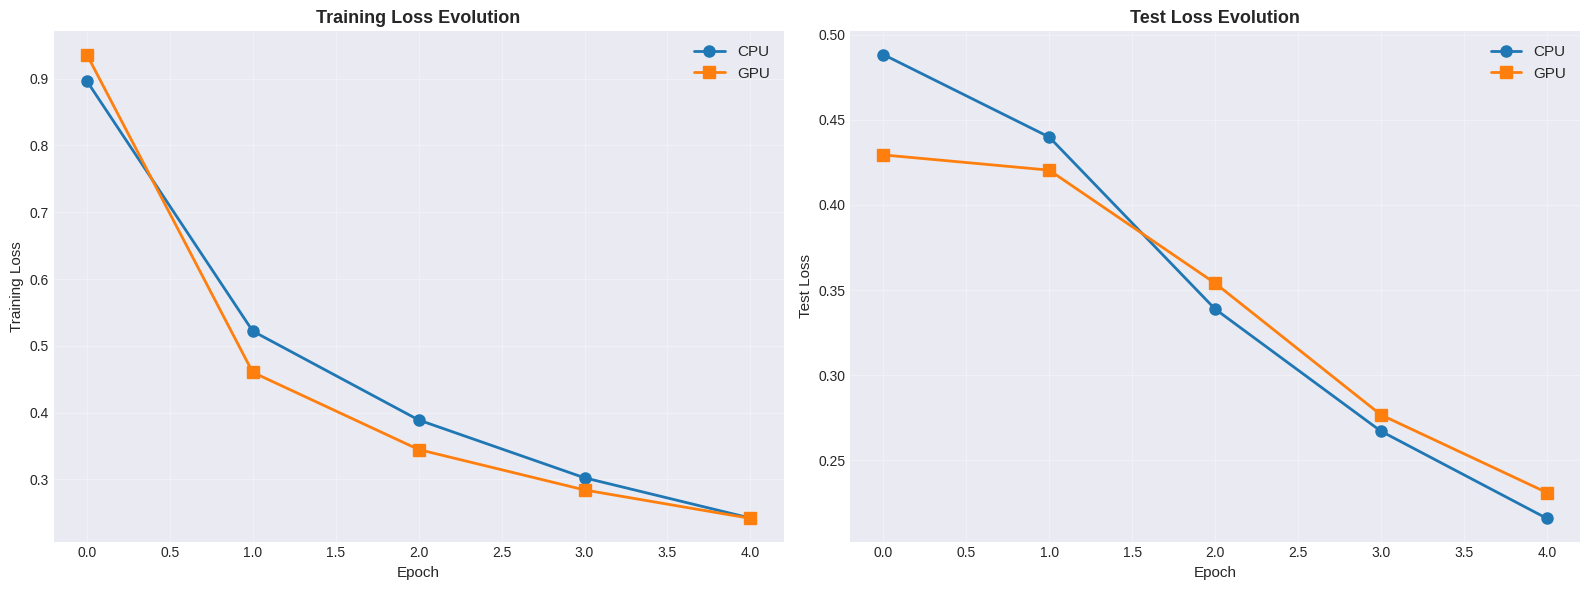

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs = range(len(cpu_results['train_losses']))

ax1.plot(epochs, cpu_results['train_losses'], 'o-', label='CPU', linewidth=2, markersize=8)
ax1.plot(epochs, gpu_results['train_losses'], 's-', label='GPU', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Training Loss', fontsize=11)
ax1.set_title('Training Loss Evolution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, cpu_results['test_losses'], 'o-', label='CPU', linewidth=2, markersize=8)
ax2.plot(epochs, gpu_results['test_losses'], 's-', label='GPU', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Test Loss', fontsize=11)
ax2.set_title('Test Loss Evolution', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Évolution du Dice Coefficient

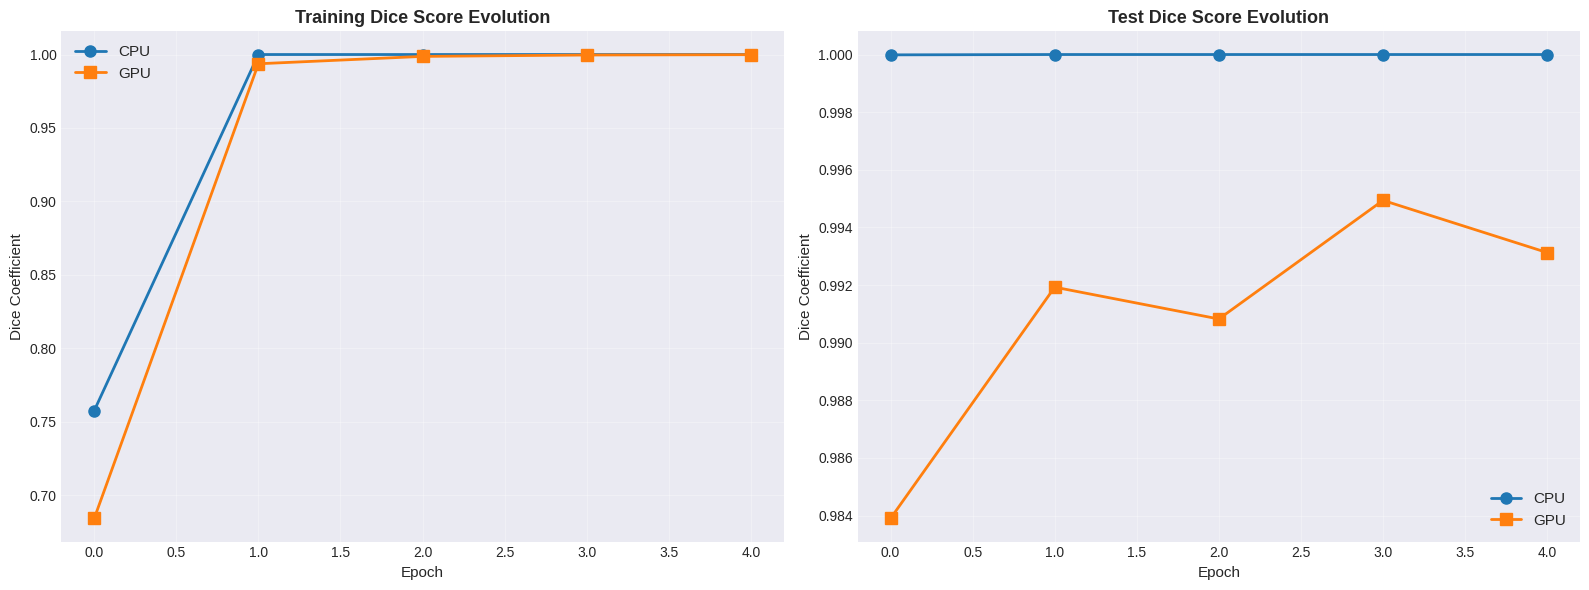

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, cpu_results['train_dice'], 'o-', label='CPU', linewidth=2, markersize=8)
ax1.plot(epochs, gpu_results['train_dice'], 's-', label='GPU', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Dice Coefficient', fontsize=11)
ax1.set_title('Training Dice Score Evolution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, cpu_results['test_dice'], 'o-', label='CPU', linewidth=2, markersize=8)
ax2.plot(epochs, gpu_results['test_dice'], 's-', label='GPU', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Dice Coefficient', fontsize=11)
ax2.set_title('Test Dice Score Evolution', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Temps par Epoch

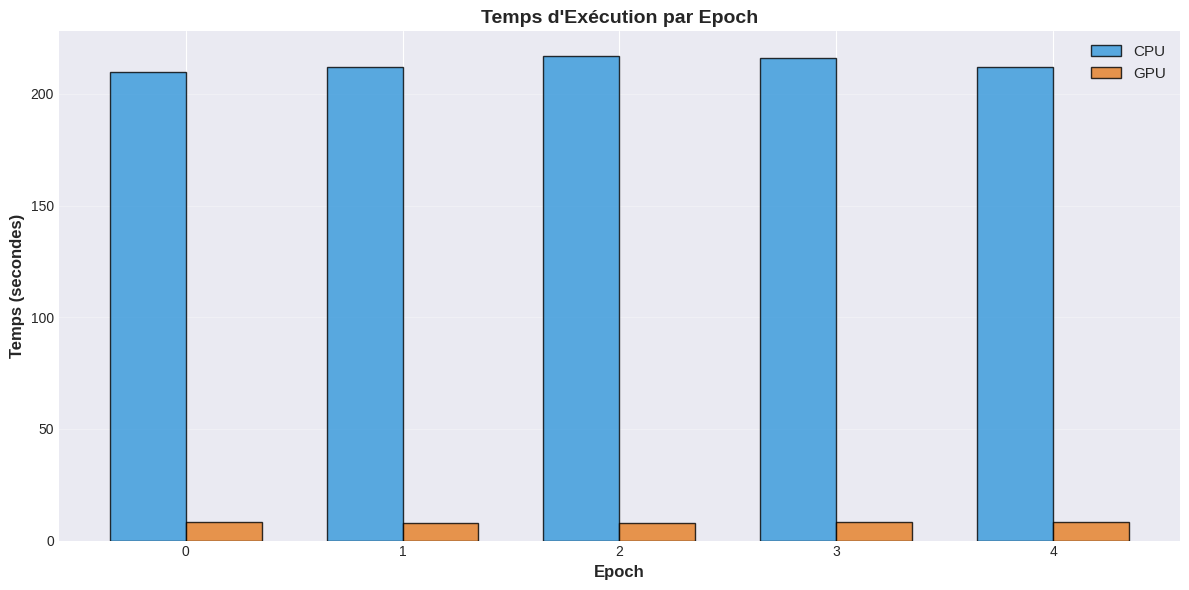

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

x = np.arange(len(epochs))
width = 0.35

bars1 = ax.bar(x - width/2, cpu_results['epoch_times'], width, label='CPU', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, gpu_results['epoch_times'], width, label='GPU', 
               color='#e67e22', alpha=0.8, edgecolor='black')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Temps (secondes)', fontsize=12, fontweight='bold')
ax.set_title('Temps d\'Exécution par Epoch', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{i}' for i in range(len(epochs))])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Analyse Détaillée

In [12]:
print("="*70)
print("ANALYSE DÉTAILLÉE - U-NET SEGMENTATION")
print("="*70)

print("\n1. ARCHITECTURE")
print("   - Encoder-Decoder avec skip connections")
print("   - 4 niveaux de résolution")
print("   - ~31M paramètres")
print("   - Convolutions, BatchNorm, Max Pooling, Transposed Conv")

print("\n2. PERFORMANCE GPU")
if speedup > 1:
    print(f"   Accélération GPU obtenue: {speedup:.2f}x")
    print(f"   Économie de temps: {(1 - gpu_time/cpu_time)*100:.1f}%")
    print("   Les opérations de convolution bénéficient du parallélisme GPU")
    print("   Les skip connections ajoutent des opérations de concatenation")
else:
    print(f"   Pas d'accélération: {speedup:.2f}x")
    print("   Possible overhead de transfert CPU-GPU")

print("\n3. QUALITÉ DU MODÈLE")
cpu_dice = cpu_results['test_dice'][-1]
gpu_dice = gpu_results['test_dice'][-1]
print(f"   Dice Score CPU: {cpu_dice:.4f}")
print(f"   Dice Score GPU: {gpu_dice:.4f}")
print(f"   Différence: {abs(cpu_dice - gpu_dice):.4f} (acceptable si < 0.01)")

print("\n4. RECOMMANDATIONS")
if speedup > 3:
    print("   Excellent speedup pour la segmentation")
    print("   L'architecture U-Net est bien adaptée au GPU")
elif speedup > 1:
    print("   Speedup modéré, considérer:")
    print("     - Augmenter la taille des batchs")
    print("     - Utiliser mixed precision (FP16)")
else:
    print("   Optimisations nécessaires:")
    print("     - Vérifier les transferts de données")
    print("     - Augmenter la taille du batch")

print("\n" + "="*70)

ANALYSE DÉTAILLÉE - U-NET SEGMENTATION

1. ARCHITECTURE
   - Encoder-Decoder avec skip connections
   - 4 niveaux de résolution
   - ~31M paramètres
   - Convolutions, BatchNorm, Max Pooling, Transposed Conv

2. PERFORMANCE GPU
   Accélération GPU obtenue: 20.65x
   Économie de temps: 95.2%
   Les opérations de convolution bénéficient du parallélisme GPU
   Les skip connections ajoutent des opérations de concatenation

3. QUALITÉ DU MODÈLE
   Dice Score CPU: 1.0000
   Dice Score GPU: 0.9931
   Différence: 0.0069 (acceptable si < 0.01)

4. RECOMMANDATIONS
   Excellent speedup pour la segmentation
   L'architecture U-Net est bien adaptée au GPU



## 10. Résumé des Résultats

In [13]:
summary = f"""
{'='*70}
RÉSUMÉ - U-NET SEGMENTATION
{'='*70}
Speedup GPU:              {speedup:>6.2f}x
Temps CPU:                {cpu_time:>6.2f}s
Temps GPU:                {gpu_time:>6.2f}s
Gain de temps:            {(1-gpu_time/cpu_time)*100:>5.1f}%
Dice Score final (CPU):   {cpu_dice:>6.4f}
Dice Score final (GPU):   {gpu_dice:>6.4f}
{'='*70}
"""

print(summary)


RÉSUMÉ - U-NET SEGMENTATION
Speedup GPU:               20.65x
Temps CPU:                1081.55s
Temps GPU:                 52.38s
Gain de temps:             95.2%
Dice Score final (CPU):   1.0000
Dice Score final (GPU):   0.9931

